In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import glob
import pandas as pd
from scipy.stats import wasserstein_distance, pearsonr, zscore, t
from scipy.special import kl_div
import matplotlib
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import seaborn as sns

import torch
from torchvision import datasets, transforms

from torch_cka import CKA

from src.model import MLP, Transformer
from src.data import ModularArithmetic, SparseParity

In [2]:
np.set_printoptions(precision=3, suppress=True)
sns.set_style("whitegrid")
matplotlib.rcParams.update({'font.size': 20})

In [4]:
# load predictions
def make_dfs(data_dir, first_n=1000):
    dfs = [
        (file, pd.read_csv(file)
        .sort_values("step")
        # .sort_values("epoch")
        .reset_index(drop=True)
        .head(first_n)
        )  
        for file in glob.glob(data_dir + "*")
    ]
    file_names, dfs = zip(*dfs)
    return file_names, dfs

def make_hmm_data(dfs, cols):
    dfs = [df[cols] for df in dfs]
    
    data = np.vstack(
        [np.apply_along_axis(zscore, 0, df.to_numpy()) for df in dfs]
    )
    return data

def break_list_by_lengths(lst, lengths):
    results = []
    start_index = 0
    
    for length in lengths:
        sublist = lst[start_index:start_index + length]
        results.append(sublist)
        start_index += length
    
    return results


def get_convergence_epochs(dfs, column, threshold=0.5):
    conv = []
    max_len = max([len(df) for df in dfs])
    for i, df in enumerate(dfs):
        first_index = df[df[column] > threshold].index.tolist()

        if first_index:
            conv.append(first_index[0])
        else:
            conv.append(max_len)
            
    return conv

def get_predictions(model_pth, data_dir, n_components, cols_to_keep):
    with open(model_pth, 'rb') as f:
        model = pickle.load(f)['best_models'][n_components-1]
    file_names, dfs = make_dfs(data_dir)
    data = make_hmm_data(dfs, cols_to_keep)
    lengths =  [len(df) for df in dfs]

    print(model.score(data, lengths=lengths))
    predictions = break_list_by_lengths(model.predict(data, lengths=lengths), lengths)
    return predictions

# convert integer vector into a count vector
def get_count_vector(prediction, n_components, threshold=10):
    prediction = prediction[:threshold]
    count_vector = np.zeros(n_components)
    for i in range(n_components):
        count_vector[i] = np.sum(prediction == i)
    return count_vector


def get_regression_vectors(file_paths, column, threshold, num_iters):
    file_names, dfs = make_dfs(file_paths)
    num_components = int(file_names[0].split('/')[-1].split('_')[0])

    x = [get_count_vector(df['latent_state'], num_components, num_iters) for df in dfs]
    # x = [normalize(get_count_vector(df['latent_state'], num_components, num_iters)) for df in dfs]
    convergence_epochs = get_convergence_epochs(dfs, column, threshold)
    avg_accuracies = [df['eval_accuracy'][-5:].mean() for df in dfs]

    return x, convergence_epochs, avg_accuracies

def get_regression_results(file_paths, column, threshold, num_iters=100):
    x, convergence_epochs, avg_accuracies = get_regression_vectors(file_paths, column, threshold, num_iters)
    model = sm.OLS(convergence_epochs, x)
    results = model.fit()
    print(results.summary())

    model = sm.OLS(avg_accuracies, x)
    results = model.fit()
    print(results.summary())

def model_selection(model_pth, data_dir, cols_to_keep, column, convergence_threshold, first_k):
    file_names, dfs = make_dfs(data_dir, first_k)
    data = make_hmm_data(dfs, cols_to_keep)
    lengths =  [len(df) for df in dfs]

    # avg_accuracy = [df['eval_accuracy'][-5:].mean() for df in dfs]
    convergence_epochs = get_convergence_epochs(dfs, column, convergence_threshold)
    print(convergence_epochs)

    for i in range(8):
        with open(model_pth, 'rb') as f:
            model = pickle.load(f)['best_models'][i]
        
        print(model.score(data, lengths=lengths)) # sanity check
        predictions = break_list_by_lengths(model.predict(data, lengths=lengths), lengths)
        # print(predictions[0])
        dfs = [df.assign(latent_state=prediction) for df, prediction in zip(dfs, predictions)]

        counts = [get_count_vector(df['latent_state'], i+1, first_k) for df in dfs]
        # print(counts[0])

        reg = LinearRegression().fit(counts, convergence_epochs)
        print(f"# components: {i+1}. R^2: {reg.score(counts, convergence_epochs)}")

    
def normalize(vector):
    return vector / np.sum(vector)
    
def get_emds(file_paths, n_components, threshold=10):
    file_names, dfs = make_dfs(file_paths)
    num_components = int(file_names[0].split('/')[-1].split('_')[0])
    n = len(dfs)
    counts = [get_count_vector(df['latent_state'], num_components, threshold=threshold) for df in dfs]
    
    emds = np.zeros((n, n))
    for i in range(len(counts)):
        # print(counts[i])
        for j in range(i):
            # https://stackoverflow.com/questions/76049158/wasserstein-distance-in-scipy-definition-of-support

            emds[i, j] = wasserstein_distance(np.arange(n_components), np.arange(n_components), normalize(counts[i]), normalize(counts[j]))
            
    # flatten, remove upper triangle and diagonal
    emds = emds[np.tril_indices(n, k=-1)]
    return emds

In [17]:
# sorting by path

d = []

for pth in glob.glob('./results/modular/*'):
    df = pd.read_csv(pth)
    latent_states = set(df['latent_state'])
    # modular
    if 5 not in latent_states and 2 not in latent_states:
    # if 5 in latent_states:
    # if 5 not in latent_states and 2 in latent_states:

    # cifar 100 destabilized
    if 1 not in latent_states:
        d.append(pth)

print(len(d))
print(d)

2
['./results/modular/6_lr0.001_adamw_seed35_scaling1.0.csv', './results/modular/6_lr0.001_adamw_seed18_scaling1.0.csv']


In [18]:
dfs = [pd.read_csv(file).sort_values("step") for file in d]
conv = get_convergence_epochs(dfs, "eval_accuracy", threshold=0.7)
print(conv, np.mean(conv), np.std(conv))

[110, 253] 181.5 71.5


[452 444 408 476 480 476 432 476 440 464 488 472 432 416 448 436 520 440
 484 440 432 456 484 508 456 440 448 448 444 472 476 444 456 440 428 444
 488 464 504 432]


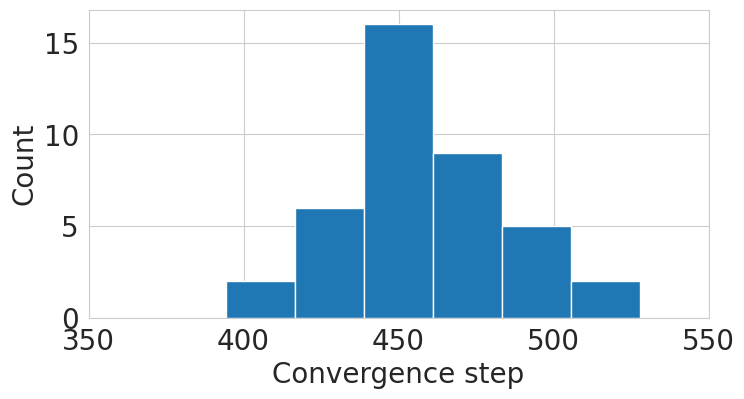

In [7]:
# file = "modular" 
# step_size = 10
# threshold = 0.9
# xmin=0
# xmax=10000

# file = "parities" 
# step_size = 1
# threshold = 0.9
# xmin=50
# xmax=200

file = "mnist_v2" 
step_size = 4
threshold = 0.97
xmin=350
xmax=550

# file = "cifar100_v3/True_True/"
# # file = "cifar100_v3/False_False/"
# step_size = 20
# # threshold = 0.4
# threshold = 0.6
# xmin=0
# xmax=12000


# dfs = [pd.read_csv(file).sort_values("step") for file in glob.glob('./results/modular/*')]
# dfs = [pd.read_csv(file).sort_values("step") for file in glob.glob('./results/modular_ln/*')]
# dfs = [pd.read_csv(file).sort_values("step") for file in glob.glob('./results/parities/*')]
# dfs = [pd.read_csv(file).sort_values("step") for file in glob.glob('./results/cifar100_v3/False_False/*')]
# dfs = [pd.read_csv(file).sort_values("step") for file in glob.glob('./results/cifar100_v3/True_True/*')]
dfs = [pd.read_csv(file).sort_values("step") for file in glob.glob(f'./results/{file}/*')]


conv = np.array(get_convergence_epochs(dfs, "eval_accuracy", threshold=threshold)) * step_size
print(conv)
plt.figure(figsize=(8,4))
bin_edges = np.linspace(xmin, xmax, num=10)

plt.hist(conv, bins=bin_edges)
plt.xlabel('Convergence step')
plt.xlim(xmin, xmax)
plt.ylabel('Count')
# plt.savefig(f"./figures/histograms/cifar100_tt", dpi=300, bbox_inches="tight")
plt.savefig(f"./figures/histograms/{file}", dpi=300, bbox_inches="tight")

In [18]:
conv

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000,
       6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000,
       6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000,
       6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [23]:
r2s = []

file_paths = '/scratch/myh2014/modeling-training/results/parities/'
file_names, dfs = make_dfs(file_paths)
for i in tqdm(range(len(dfs[0]['latent_state']))):
    x, convergence_epochs, avg_accuracies = get_regression_vectors(file_paths, 'eval_accuracy', 0.9, i)
    model = sm.OLS(convergence_epochs, x)
    results = model.fit()
    r2s.append(results.rsquared)
    
sns.lineplot(x=np.arange(300), y=r2s)
plt.xlabel("Top $k$ epochs")
plt.ylabel("$R^2$")
plt.savefig("./figures/deeper_analyses/parities_inc_pred.png")

100%|██████████| 300/300 [00:43<00:00,  6.87it/s]


100%|██████████| 1000/1000 [03:33<00:00,  4.68it/s]


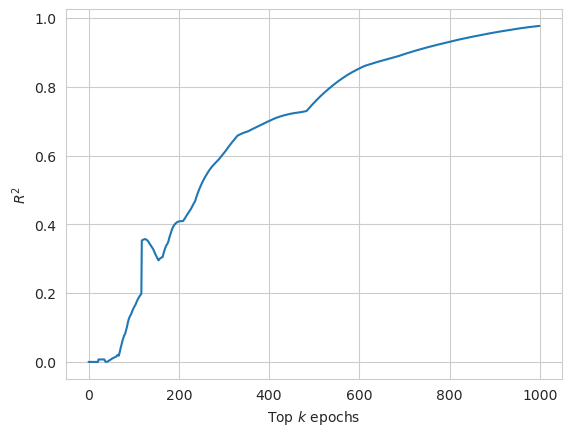

In [29]:
r2s = []

file_paths = '/scratch/myh2014/modeling-training/results/modular/'
file_names, dfs = make_dfs(file_paths)
for i in tqdm(range(len(dfs[0]['latent_state']))):
    x, convergence_epochs, avg_accuracies = get_regression_vectors(file_paths, 'eval_accuracy', 0.9, i)
    model = sm.OLS(convergence_epochs, x)
    results = model.fit()
    r2s.append(results.rsquared)
    
sns.lineplot(x=np.arange(1000), y=r2s)
plt.xlabel("Top $k$ epochs")
plt.ylabel("$R^2$")
plt.savefig("./figures/deeper_analyses/modular_inc_pred.png")

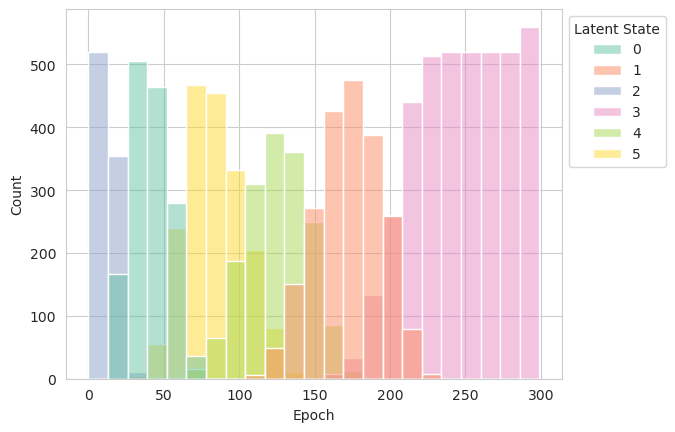

In [66]:
file_paths = '/scratch/myh2014/modeling-training/results/parities/'
file_names, dfs = make_dfs(file_paths)
df = pd.concat(dfs)

# fig, ax = plt.subplots(figsize=(10, 5))
df.rename(columns={'step': 'Epoch', 'latent_state': 'Latent State'}, inplace=True)
ax = sns.histplot(data=df, x='Epoch', hue='Latent State', palette='Set2', kde=False, legend=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig("./figures/deeper_analyses/parities_phase_onset.png", bbox_inches='tight')

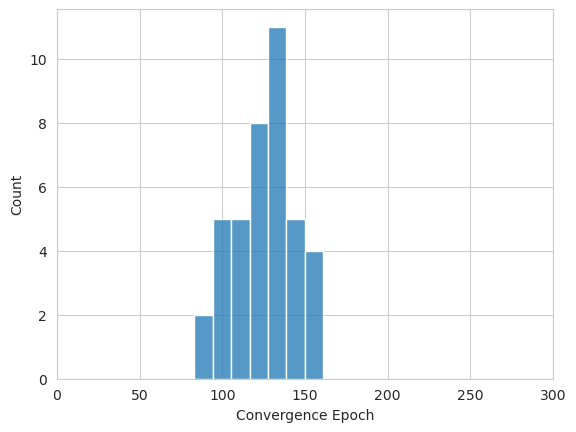

In [72]:
_, convergence_epochs,_ = get_regression_vectors(file_paths, 'eval_accuracy', 0.9, i)
ax = sns.histplot(x=convergence_epochs)
ax.set_xlim([0, 300])
ax.set_xlabel("Convergence Epoch")
plt.savefig("./figures/deeper_analyses/parities_convergence_epoch.png", bbox_inches='tight')

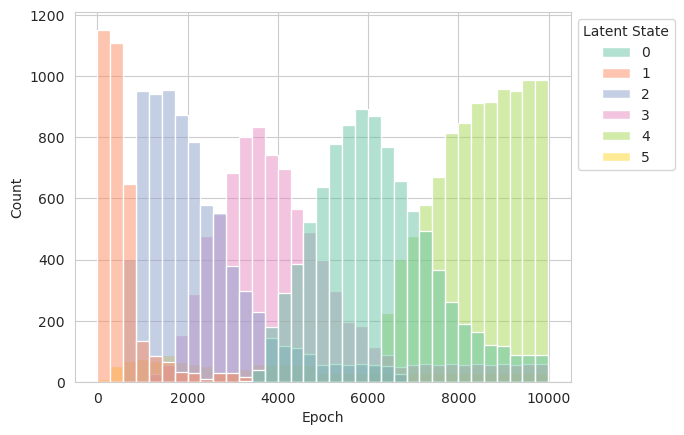

In [73]:
file_paths = '/scratch/myh2014/modeling-training/results/modular/'
file_names, dfs = make_dfs(file_paths)
df = pd.concat(dfs)

df.rename(columns={'step': 'Epoch', 'latent_state': 'Latent State'}, inplace=True)
ax = sns.histplot(data=df, x='Epoch', hue='Latent State', palette='Set2', kde=False, legend=True)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig("./figures/deeper_analyses/modular_phase_onset.png", bbox_inches='tight')

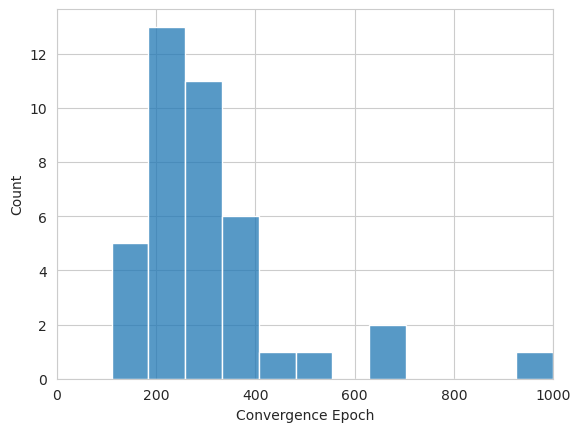

In [75]:
_, convergence_epochs,_ = get_regression_vectors(file_paths, 'eval_accuracy', 0.9, i)
ax = sns.histplot(x=convergence_epochs)
ax.set_xlim([0, 1000])
ax.set_xlabel("Convergence Epoch")
plt.savefig("./figures/deeper_analyses/modular_convergence_epoch.png", bbox_inches='tight')

In [43]:
first_transitions = []
for file_name, df in zip(file_names, dfs):
    transition = 0
    latent_state = df['latent_state']
    bigrams = [(x[0], x[1]) for x in zip(latent_state[:-1], latent_state[1:])]
    for bigram in bigrams:
        if bigram[1] != 2:
            first_transitions.append(bigram[1])
            break
#     if (1, 3) in bigrams:
#         transition = 3
#     if (1, 2) in bigrams:
#         transition = 2
#     if (1, 5) in bigrams:
#         transition = 5
        
#     first_transitions.append(transition)

In [40]:
len(np.where(np.array(first_transitions) == 2)[0])

34

In [41]:
len(np.where(np.array(first_transitions) == 5)[0])

4

In [12]:
np.where(np.array(r2s[:200]) > 0.35)

(array([118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
        131, 132, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
        188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]),)

In [13]:
r2s[200]

0.4082474677001976

In [14]:
r2s[118]

0.3528509092330132

In [15]:
x, convergence_epochs, avg_accuracies = get_regression_vectors(file_paths, 'eval_accuracy', 0.9, 118)
model = sm.OLS(convergence_epochs, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     6.543
Date:                Wed, 19 Jul 2023   Prob (F-statistic):            0.00120
Time:                        14:05:23   Log-Likelihood:                -251.26
No. Observations:                  40   AIC:                             510.5
Df Residuals:                      36   BIC:                             517.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0          0        nan        n

/ext3/miniconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


# Model selection

In [4]:
# cols_to_keep = [
#     "l1",
#     "l2",
#     "trace",
#     "spectral",
#     "code_sparsity",
#     "computational_sparsity",
#     "mean_singular_value",
#     "var_singular_value",
#     "mean_w",
#     "median_w",
#     "var_w",
#     "mean_b",
#     "median_b",
#     "var_b",
# ]

cols_to_keep = [
    "l1",
    "l2",
    "trace",
    "spectral",
    "code_sparsity",
    "computational_sparsity",
    "mean_lambda",
    "variance_lambda",
    "mean_w",
    "median_w",
    "var_w",
    "mean_b",
    "median_b",
    "var_b",
]

In [67]:
model_selection(
    model_pth='/scratch/myh2014/modeling-training/data/model_selection/32/cifar100_cnn--base.pkl',
    data_dir = '/scratch/myh2014/modeling-training/data/training_runs/cifar100_cnn/',
    cols_to_keep=cols_to_keep,
    column='eval_accuracy',
    convergence_threshold=0.60,
    first_k=300
)

[91, 94, 82, 86, 88, 89, 89, 93, 92, 95, 92, 90, 86, 89, 87, 90, 91, 90, 89, 90, 89, 89, 96, 87, 87, 90, 88, 85, 98, 93, 93, 94, 90, 90, 96, 89, 86, 91, 95, 91]
205504.02080352174
# components: 1. R^2: 0.0
276525.7746328428
# components: 2. R^2: 0.019411854815455598
301467.9701345866
# components: 3. R^2: 0.02249134948096887
316236.3011358438
# components: 4. R^2: 0.1895916600085089
325435.1311040439
# components: 5. R^2: 0.14067906574394462
333057.65814590943
# components: 6. R^2: 0.023952271905465672
334105.97252474184
# components: 7. R^2: 0.0982553159297791
338621.0483907891
# components: 8. R^2: -0.014994232987312506


In [66]:
model_selection(
    model_pth='/scratch/myh2014/modeling-training/data/model_selection/32/mnist_cnn/mnist_cnn--base.pkl',
    data_dir = '/scratch/myh2014/modeling-training/data/training_runs/mnist_cnn/',
    cols_to_keep=cols_to_keep,
    column='eval_accuracy',
    convergence_threshold=0.97,
    first_k=200
)

[23, 27, 25, 30, 26, 30, 25, 23, 19, 29, 26, 27, 33, 24, 19, 32, 25, 26, 30, 32, 22, 28, 27, 27, 25, 24, 28, 34, 23, 21, 24, 30, 29, 30, 26, 22, 28, 25, 30, 22]
81760.31059254076
# components: 1. R^2: 0.0
110959.42640951341
# components: 2. R^2: 0.005458007066462822
126598.21097635025
# components: 3. R^2: 0.09377387318563768
134789.4550244703
# components: 4. R^2: -0.02941176470588247
140388.41684841784
# components: 5. R^2: 0.08708938120702814
143328.17944896797
# components: 6. R^2: 0.04525569620391734
143184.46866548498
# components: 7. R^2: 0.13488030822105213
145657.42811710283
# components: 8. R^2: 0.28216699471486006


In [16]:
a, b  = make_dfs('/scratch/myh2014/modeling-training/data/training_runs/mnist_cnn/')

In [21]:
preds = get_predictions(
    model_pth='/scratch/myh2014/modeling-training/data/model_selection/32/mnist_cnn--base.pkl',
    data_dir = '/scratch/myh2014/modeling-training/data/training_runs/mnist_cnn/',
    cols_to_keep=cols_to_keep,
    n_components=8
)

751186.0417545151


In [23]:
with open('/scratch/myh2014/modeling-training/data/model_selection/32/mnist_cnn--base.pkl', 'rb') as f:
    data = pickle.load(f)

In [24]:
data

{'best_scores': [94057.99021421687,
  117991.79309827178,
  128236.98804934032,
  136465.69227302578,
  141767.0398890583,
  142904.01871562924,
  143988.31466103758,
  145578.23478592793],
 'mean_scores': [94057.99021421687,
  116781.01146042936,
  126770.79348906214,
  133683.0477332395,
  139253.2018829196,
  138035.54483423274,
  139042.92116224242,
  143857.55984941297],
 'scores_stdev': [0.0,
  2347.0556943976435,
  2575.6876132437615,
  3159.8000519799875,
  1932.6706047836926,
  2555.0459689269474,
  4773.935897994586,
  870.293835478457],
 'aics': [-187877.98042843374,
  -233080.02292085873,
  -252811.58697812428,
  -266384.095466479,
  -277268.4037658392,
  -274573.0896684655,
  -276323.84232448484,
  -285685.11969882593],
 'bics': [-187054.1206410421,
  -231411.53377160343,
  -250284.6220840239,
  -262984.80844455224,
  -272982.9482331044,
  -269387.6192419416,
  -270224.5106211904,
  -278658.08033577964],
 'best_models': [GaussianHMM(covariance_type='full', n_iter=32),
  Ga

In [42]:
model_selection(
    model_pth='/scratch/myh2014/modeling-training/data/model_selection/32/modular/modular_v3_run2-full-base.pkl',
    data_dir = '/scratch/myh2014/modeling-training/data/training_runs/modular_v3/',
    cols_to_keep=cols_to_keep,
    column='eval_accuracy',
    threshold=0.5
)

# components: 1. R^2: 0.0
# components: 2. R^2: 0.2285468336762141
# components: 3. R^2: 0.413606890107978
# components: 4. R^2: 0.33986112485725084
# components: 5. R^2: 0.4592461823123789
# components: 6. R^2: 0.6395763791450221
# components: 7. R^2: 0.8974579869928047
# components: 8. R^2: 0.8725174386452004


In [14]:
# model_pth='/scratch/myh2014/modeling-training/data/model_selection/32/modular_v3-diag-ablation2.pkl'
# data_dir = '/scratch/myh2014/modeling-training/data/training_runs/modular_v3/'
# model_pth='/scratch/myh2014/modeling-training/data/model_selection/32/parities/parities_v3-full-base.pkl'
data_dir = '/scratch/myh2014/modeling-training/data/training_runs/parities_v3/'

cols = ['spectral', 'variance_lambda', 'mean_lambda', 'l2', 'var_w', 'l1',
        'code_sparsity', 'var_b', 'mean_b', 'median_b', 'trace',
        'computational_sparsity', 'mean_w', 'median_w']

column='eval_accuracy'
threshold=0.9
num_components = [8,8,8,8,6,8,8,7,7,8,8,6,5,6]
r2s = []


for i, num_components in enumerate(num_components):
    print(cols[:i+1])
    file_names, dfs = make_dfs(data_dir)
    data = make_hmm_data(dfs, cols[:i+1])
    lengths =  [len(df) for df in dfs]
    convergence_epochs = get_convergence_epochs(dfs, column, threshold)


    with open(f'/scratch/myh2014/modeling-training/data/model_selection/32/parities_v3--parities{i+1}.pkl', 'rb') as f:
        model = pickle.load(f)['best_models'][num_components-1]

    print(model.score(data, lengths=lengths)) # sanity check
    predictions = break_list_by_lengths(model.predict(data, lengths=lengths), lengths)
    # print(predictions)
    counts = [get_count_vector(prediction, i+1, 1000) for prediction in predictions]
    # print(counts)

    model = sm.OLS(convergence_epochs, counts)
    results = model.fit()
    r2s.append(results.rsquared)

['spectral']
5623.981091808399
['spectral', 'variance_lambda']
698.7738796153207
['spectral', 'variance_lambda', 'mean_lambda']
16854.39957035916
['spectral', 'variance_lambda', 'mean_lambda', 'l2']
42362.7211873983
['spectral', 'variance_lambda', 'mean_lambda', 'l2', 'var_w']
82187.21235653406
['spectral', 'variance_lambda', 'mean_lambda', 'l2', 'var_w', 'l1']
118318.487992054
['spectral', 'variance_lambda', 'mean_lambda', 'l2', 'var_w', 'l1', 'code_sparsity']
163040.91256963968
['spectral', 'variance_lambda', 'mean_lambda', 'l2', 'var_w', 'l1', 'code_sparsity', 'var_b']
177382.94271609903
['spectral', 'variance_lambda', 'mean_lambda', 'l2', 'var_w', 'l1', 'code_sparsity', 'var_b', 'mean_b']
192972.87008682522
['spectral', 'variance_lambda', 'mean_lambda', 'l2', 'var_w', 'l1', 'code_sparsity', 'var_b', 'mean_b', 'median_b']
211427.30897017688
['spectral', 'variance_lambda', 'mean_lambda', 'l2', 'var_w', 'l1', 'code_sparsity', 'var_b', 'mean_b', 'median_b', 'trace']
199646.0482692083
[

Text(0.5, 1.0, 'Sparse parities')

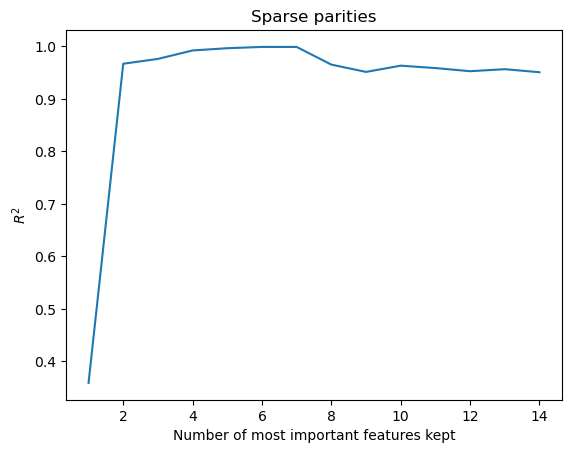

In [5]:
r2s[13] = 0.961
plt.plot(np.arange(1, 15), r2s)
plt.xlabel("Number of most important features kept")
plt.ylabel("$R^2$")
plt.title("Sparse parities")

In [76]:
data_dir = '/scratch/myh2014/modeling-training/data/training_runs/modular_v3/'

cols = ['var_w', 'l1', 'l2', 'mean_lambda', 'variance_lambda', 'spectral',
        'code_sparsity', 'mean_b', 'computational_sparsity', 'trace', 'median_b',
        'var_b', 'median_w', 'mean_w']

column='eval_accuracy'
threshold=0.9
num_components = [8,8,8,7,8,8,8,8,7,5,6,5,7,7]
r2s = []


for i, components in enumerate(num_components):
    print(cols[:i+1])
    file_names, dfs = make_dfs(data_dir)
    data = make_hmm_data(dfs, cols[:i+1])
    lengths =  [len(df) for df in dfs]
    convergence_epochs = get_convergence_epochs(dfs, column, threshold)

    
    with open(f'/scratch/myh2014/modeling-training/data/model_selection/32/modular_v3--modular{i+1}.pkl', 'rb') as f:
        model = pickle.load(f)['best_models'][components-1]

    print(model.score(data, lengths=lengths)) # sanity check
    predictions = break_list_by_lengths(model.predict(data, lengths=lengths), lengths)
    # print(predictions)
    counts = [get_count_vector(prediction, i+1, 1000) for prediction in predictions]
    # print(counts)

    model = sm.OLS(convergence_epochs, counts)
    results = model.fit()
    r2s.append(results.rsquared)

['var_w']
18743.906220923025
['var_w', 'l1']
62299.142788401914
['var_w', 'l1', 'l2']
149485.18762422708
['var_w', 'l1', 'l2', 'mean_lambda']
227459.19683425518
['var_w', 'l1', 'l2', 'mean_lambda', 'variance_lambda']
287310.26038765174
['var_w', 'l1', 'l2', 'mean_lambda', 'variance_lambda', 'spectral']
364181.743544243
['var_w', 'l1', 'l2', 'mean_lambda', 'variance_lambda', 'spectral', 'code_sparsity']
419691.3176235953
['var_w', 'l1', 'l2', 'mean_lambda', 'variance_lambda', 'spectral', 'code_sparsity', 'mean_b']
460085.7740107683
['var_w', 'l1', 'l2', 'mean_lambda', 'variance_lambda', 'spectral', 'code_sparsity', 'mean_b', 'computational_sparsity']
340472.4128350948
['var_w', 'l1', 'l2', 'mean_lambda', 'variance_lambda', 'spectral', 'code_sparsity', 'mean_b', 'computational_sparsity', 'trace']
303577.1581361302
['var_w', 'l1', 'l2', 'mean_lambda', 'variance_lambda', 'spectral', 'code_sparsity', 'mean_b', 'computational_sparsity', 'trace', 'median_b']
338310.05453808006
['var_w', 'l1',

In [77]:
r2s

[0.5477777913706459,
 0.8041712031946289,
 0.9699374626299141,
 0.9945934527796734,
 0.7976090959164397,
 0.9870637112136389,
 0.9742057349455273,
 0.9151564476008691,
 0.9836072525478654,
 0.8613170877458565,
 0.9523529744566442,
 0.9820322274345554,
 0.9956349915232714,
 0.7821811073374538]

In [10]:
r2s[13] = 0.977

Text(0.5, 1.0, 'Modular addition')

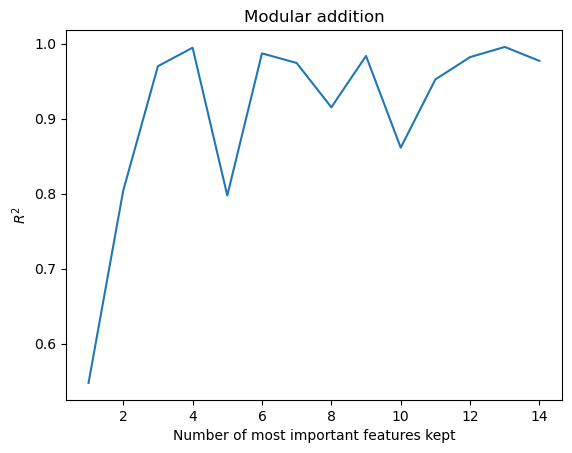

In [11]:
plt.plot(np.arange(1, 15), r2s)
plt.xlabel("Number of most important features kept")
plt.ylabel("$R^2$")
plt.title("Modular addition")

In [12]:
data_dir = '/scratch/myh2014/modeling-training/data/training_runs/modular_v3/'

cols = ['spectral', 'variance_lambda']

column='eval_accuracy'
threshold=0.9
num_components = 7


file_names, dfs = make_dfs(data_dir)
data = make_hmm_data(dfs, cols)
lengths =  [len(df) for df in dfs]
convergence_epochs = get_convergence_epochs(dfs, column, threshold)


with open(f'/scratch/myh2014/modeling-training/data/model_selection/32/modular_v3_swap--parities_best.pkl', 'rb') as f:
    model = pickle.load(f)['best_models'][num_components-1]

print(model.score(data, lengths=lengths)) # sanity check
predictions = break_list_by_lengths(model.predict(data, lengths=lengths), lengths)
counts = [get_count_vector(prediction, i+1, 1000) for prediction in predictions]

model = sm.OLS(convergence_epochs, counts)
results = model.fit()
print(results.summary())

61092.80095815406
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     33.30
Date:                Fri, 21 Jul 2023   Prob (F-statistic):           1.22e-12
Time:                        11:09:32   Log-Likelihood:                -220.90
No. Observations:                  40   AIC:                             455.8
Df Residuals:                      33   BIC:                             467.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3819      0.147  

/ext3/miniconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [13]:
data_dir = '/scratch/myh2014/modeling-training/data/training_runs/parities_v3/'

cols = ['var_w', 'l1', 'l2']

column='eval_accuracy'
threshold=0.9
num_components = 7


file_names, dfs = make_dfs(data_dir)
data = make_hmm_data(dfs, cols)
lengths =  [len(df) for df in dfs]
convergence_epochs = get_convergence_epochs(dfs, column, threshold)


with open(f'/scratch/myh2014/modeling-training/data/model_selection/32/parities_v3_swap--modular_best.pkl', 'rb') as f:
    model = pickle.load(f)['best_models'][num_components-1]

print(model.score(data, lengths=lengths)) # sanity check
predictions = break_list_by_lengths(model.predict(data, lengths=lengths), lengths)
counts = [get_count_vector(prediction, i+1, 1000) for prediction in predictions]

model = sm.OLS(convergence_epochs, counts)
results = model.fit()
print(results.summary())

58963.10831136395
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     108.9
Date:                Fri, 21 Jul 2023   Prob (F-statistic):           2.65e-20
Time:                        11:11:11   Log-Likelihood:                -112.07
No. Observations:                  40   AIC:                             238.1
Df Residuals:                      33   BIC:                             250.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9801      0.189  

/ext3/miniconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [17]:
data_dir = '/scratch/myh2014/modeling-training/results/mnist_250/*seed0*'
file_names, dfs = make_dfs(data_dir)
data = make_hmm_data(dfs, cols_to_keep)

# Full prediction results for the best models

In [13]:
get_regression_results(
    file_paths = '/scratch/myh2014/modeling-training/results/modular/',
    column = 'eval_accuracy',
    threshold = 0.9,
    num_iters=1000
)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     287.1
Date:                Fri, 21 Jul 2023   Prob (F-statistic):           8.85e-27
Time:                        10:49:03   Log-Likelihood:                -184.64
No. Observations:                  40   AIC:                             381.3
Df Residuals:                      34   BIC:                             391.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -153.6864     47.370     -3.244      0.0

In [79]:
get_regression_results(
    file_paths = '/scratch/myh2014/modeling-training/results/parities/',
    column = 'eval_accuracy',
    threshold = 0.9,
    num_iters=1000
)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     166.2
Date:                Fri, 21 Jul 2023   Prob (F-statistic):           7.08e-23
Time:                        15:36:33   Log-Likelihood:                -108.04
No. Observations:                  40   AIC:                             228.1
Df Residuals:                      34   BIC:                             238.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.7782      0.103      7.579      0.0

In [8]:
get_regression_results(
    file_paths = '/scratch/myh2014/modeling-training/results/mnist_v2/',
    column = 'eval_accuracy',
    threshold = 0.97
)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                 -0.031
Method:                 Least Squares   F-statistic:                    0.6131
Date:                Mon, 14 Aug 2023   Prob (F-statistic):              0.611
Time:                        13:00:27   Log-Likelihood:                -129.01
No. Observations:                  40   AIC:                             266.0
Df Residuals:                      36   BIC:                             272.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const               0          0        nan        n

/ext3/miniconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/ext3/miniconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [6]:
get_regression_results(
    file_paths = '/scratch/myh2014/modeling-training/results/cifar100_v3/False_False/',
    column = 'eval_accuracy',
    threshold = 0.4,
    num_iters=300
)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     82.98
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           2.33e-17
Time:                        21:53:40   Log-Likelihood:                -211.24
No. Observations:                  40   AIC:                             432.5
Df Residuals:                      35   BIC:                             440.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6554      0.328      1.996      0.0

In [4]:
get_regression_results(
    file_paths = '/scratch/myh2014/modeling-training/results/parities_adam_ln/',
    column = 'eval_accuracy',
    threshold = 0.9,
    num_iters=1000
)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     7.282
Date:                Mon, 14 Aug 2023   Prob (F-statistic):             0.0107
Time:                        12:41:15   Log-Likelihood:                -126.86
No. Observations:                  37   AIC:                             257.7
Df Residuals:                      35   BIC:                             260.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3470      0.058      5.981      0.0

In [7]:
get_regression_results(
    file_paths = '/scratch/myh2014/modeling-training/results/cifar100_v3/True_True/',
    column = 'eval_accuracy',
    threshold = 0.4,
    num_iters=300
)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.9106
Date:                Wed, 09 Aug 2023   Prob (F-statistic):              0.469
Time:                        21:54:19   Log-Likelihood:                -76.397
No. Observations:                  40   AIC:                             162.8
Df Residuals:                      35   BIC:                             171.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2131      0.197      1.081      0.2

In [8]:
get_regression_results(
    file_paths = '/scratch/myh2014/modeling-training/results/modular_ln/',
    column = 'eval_accuracy',
    threshold = 0.5,
    num_iters=300
)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.488
Method:                 Least Squares   F-statistic:                     19.58
Date:                Wed, 09 Aug 2023   Prob (F-statistic):           1.58e-06
Time:                        22:18:07   Log-Likelihood:                -53.447
No. Observations:                  40   AIC:                             112.9
Df Residuals:                      37   BIC:                             118.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.4100      0.450      3.136      0.0

In [21]:
class XOnlyDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
    
    def __getitem__(self, index):
        x, y = self.original_dataset[index]
        return x
    
    def __len__(self):
        return len(self.original_dataset)

In [ ]:
# correlation between paths and CKA
# note: this analysis takes a really long time. we're running at max batch size, 
# so it's hard to speed it up without further engineering work
# running on the entire trajectory would take like 250 hours.

# MNIST
data_dir = './data/raw/mnist_v3'
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.flatten(x)),
    ]
)
# compare on the validation set
data = datasets.MNIST(
    "./data", train=False, download=True, transform=transform
)
dataloader = torch.utils.data.DataLoader(
    XOnlyDataset(data), batch_size=10000, shuffle=False
)
torch.manual_seed(0)

model1 = MLP(input_dim=784, hidden_dims=[800, 800], output_dim=10)
model2 = MLP(input_dim=784, hidden_dims=[800, 800], output_dim=10)

data_arr = np.zeros((3, 40, 40))

for seed_i in range(40):
    for seed_j in range(0, seed_i):
        model1.load_state_dict(torch.load(
            glob.glob(data_dir + f'/*seed{seed_i}*/model_2348.pt')[0]
        ))
        model2.load_state_dict(torch.load(
            glob.glob(data_dir + f'/*seed{seed_j}*/model_2348.pt')[0]
        ))

        cka = CKA(model1, model2,
                    model1_name="MLP1",
                    model2_name="MLP2",
                    model1_layers=['layers.0', 'layers.1', 'layers.2'],
                    model2_layers=['layers.0', 'layers.1', 'layers.2'],
                    device='cuda'
        )
        
        with torch.no_grad():
            cka.compare(dataloader, only_compare_diagonals=True)
            cka_out = cka.export()
        
        data_arr[:, seed_i, seed_j] = cka_out['CKA'].diag().numpy()

In [77]:
ckas = data_arr[1][np.tril_indices(40, k=-1)]
emds = get_emds('/scratch/myh2014/modeling-training/results/mnist/')

corr, pval = pearsonr(emds[ckas < 0.98], ckas[ckas < 0.98])
print(corr)
print(pval)

0.1958741599705748
3.701039854527503e-08


In [ ]:
# modular addition

data = ModularArithmetic("add")
dataloader = torch.utils.data.DataLoader(XOnlyDataset(data), batch_size=113*113, shuffle=False)

model1 = Transformer(d_model=128, d_head=32, d_vocab=114, num_heads=4, num_layers=1, n_ctx=3)
model2 = Transformer(d_model=128, d_head=32, d_vocab=114, num_heads=4, num_layers=1, n_ctx=3)

data_dir = './data/raw/modular_v3'
data_arr = np.zeros((1, 40, 40))

for seed_i in range(40):
    for seed_j in range(0, seed_i):
        model1.load_state_dict(torch.load(
            glob.glob(data_dir + f'/*seed{seed_i}*/model.pt')[0]
        ))
        model2.load_state_dict(torch.load(
            glob.glob(data_dir + f'/*seed{seed_j}*/model.pt')[0]
        ))

        cka = CKA(model1, model2,
                    model1_name="MLP1",
                    model2_name="MLP2",
                    model1_layers=['blocks.0.mlp'],
                    model2_layers=['blocks.0.mlp'],
                    device='cuda'
        )
        
        with torch.no_grad():
            cka.compare(dataloader, only_compare_diagonals=True)
            cka_out = cka.export()
        
        data_arr[:, seed_i, seed_j] = cka_out['CKA'].diag().numpy()
        
np.savez("./results/cka_modular_addition.npz", data_arr)

In [40]:
ckas = data_arr[0][np.tril_indices(40, k=-1)]
emds = get_emds('/scratch/myh2014/modeling-training/results/modular/')

corr, pval = pearsonr(emds, ckas) #  < 0.98], ckas[ckas < 0.98])
print(corr)
print(pval)

0.035103880866628474
0.3275169811131045


In [ ]:
# sparse parity

data = SparseParity(10000, 40, 3)
dataloader = torch.utils.data.DataLoader(XOnlyDataset(data), batch_size=10000, shuffle=False)

model1 = MLP(input_dim=40, hidden_dims=[1000], output_dim=1, kaiming_uniform=False)
model2 = MLP(input_dim=40, hidden_dims=[1000], output_dim=1, kaiming_uniform=False)

data_dir = './data/raw/parities_v3'
data_arr = np.zeros((2, 40, 40))

for seed_i in range(40):
    for seed_j in range(0, seed_i):
        model1.load_state_dict(torch.load(
            glob.glob(data_dir + f'/*seed{seed_i}*/model.pt')[0]
        ))
        model2.load_state_dict(torch.load(
            glob.glob(data_dir + f'/*seed{seed_j}*/model.pt')[0]
        ))

        cka = CKA(model1, model2,
                    model1_name="MLP1",
                    model2_name="MLP2",
                    model1_layers=['layers.0', 'layers.1'],
                    model2_layers=['layers.0', 'layers.1'],
                    device='cuda'
        )
        
        with torch.no_grad():
            cka.compare(dataloader, only_compare_diagonals=True)
            cka_out = cka.export()
        
        data_arr[:, seed_i, seed_j] = cka_out['CKA'].diag().numpy()
        
np.savez("./results/cka_sparse_parities.npz", data_arr)

In [37]:
ckas = data_arr[1][np.tril_indices(40, k=-1)]
emds = get_emds('/scratch/myh2014/modeling-training/results/parities/')

corr, pval = pearsonr(emds, ckas) #  < 0.98], ckas[ckas < 0.98])
print(corr)
print(pval)

-0.1176720423087612
0.0009927400182599584


In [12]:
print(np.mean(get_emds('/scratch/myh2014/modeling-training/results/mnist_v2/', 6, 1000)))
# print(np.mean(get_emds('/scratch/myh2014/modeling-training/results/parities/')))
# print(np.mean(get_emds('/scratch/myh2014/modeling-training/results/modular/')))

0.06279999999999998


In [11]:
print(np.mean(get_emds('/scratch/myh2014/modeling-training/results/modular_ln/', 3, threshold=1000)))
print(np.mean(get_emds('/scratch/myh2014/modeling-training/results/cifar100_v3/False_False/', 5, threshold=1000)))
print(np.mean(get_emds('/scratch/myh2014/modeling-training/results/cifar100_v3/True_True/', 5, threshold=1000)))

0.03846153846153844
0.8058290598290597
0.028397435897435933


In [6]:
print(np.mean(get_emds('/scratch/myh2014/modeling-training/results/parities_adam_ln/', 2, threshold=1000)))

0.4621621621621621


In [18]:
# need to change step --> epoch again
print(np.mean(get_emds('/scratch/myh2014/modeling-training/results/multiberts_diag/')))

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
0.0


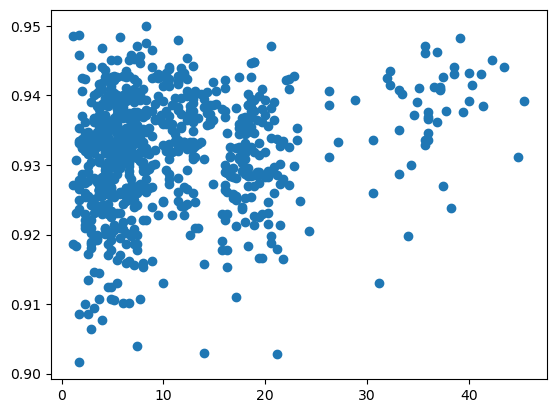

In [66]:
plt.scatter(emds[ckas < 0.98], ckas[ckas < 0.98])